# SET UP

### TODO:

- [ ] Examine feature importance
- [ ] Address potential multicollinearity between OL and passing features
     - [ ] Use PCA or regularization
- [ ] Rename project (?)
- [ ] Rename graphs
- [ ] Reorganize code (?)

In [1]:
import math
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, mean_absolute_error
from xgboost import XGBRegressor, plot_tree


In [2]:
# Configurations
pd.set_option('display.max_columns', None)

In [3]:
# Initialize dictionary of dataframes

adv_pass = {}
data = {}
years = [19, 20, 21, 22, 23, 24]


In [4]:
# Load CSVs per year

# NOTE: You can comment out a line if you already have the data and don't want to import it
for x in years:
    adv_pass[x] = pd.read_csv('data/passing_adv_20' + str(x) + '.csv')

print("done")


done


In [5]:
# Extract subsets of columns we want from CSVs into dataframes we will use for calculations

# TODO: rename these columns (e.g. 'name_display' to 'player', 'team_name_abbr' to 'tm', 'pass_cmp' to 'cmp', etc.)
for x in years:
    df = adv_pass[x]
    df = df[df['pass_att'] >= 250] # Drop passers who don't have at least 250 pass attempts
    data[x] = df[['name_display', 'team_name_abbr', 'pass_cmp', 'pass_att', 'pass_batted_passes', 'pass_throwaways', 'pass_spikes', 
                        'pass_drops', 'pass_poor_throws','pass_on_target', 'pocket_time', 'pass_blitzed', 'pass_hurried',
                        'pass_hits', 'pass_pressured', 'rush_scrambles']]
    


In [6]:
# Color Palette
# Map each team to its respective hex color

nfl_team_colors = {
    'ARI': '#97233F',  # Arizona Cardinals
    'ATL': '#A71930',  # Atlanta Falcons
    'BAL': '#241773',  # Baltimore Ravens
    'BUF': '#00338D',  # Buffalo Bills
    'CAR': '#0085CA',  # Carolina Panthers
    'CHI': '#0B162A',  # Chicago Bears
    'CIN': '#FB4F14',  # Cincinnati Bengals
    'CLE': '#311D00',  # Cleveland Browns
    'DAL': '#003594',  # Dallas Cowboys
    'DEN': '#FB4F14',  # Denver Broncos
    'DET': '#0076B6',  # Detroit Lions
    'GNB':  '#203731',  # Green Bay Packers
    'HOU': '#03202F',  # Houston Texans
    'IND': '#002C5F',  # Indianapolis Colts
    'JAX': '#006778',  # Jacksonville Jaguars
    'KAN':  '#E31837',  # Kansas City Chiefs
    'LAC': '#0073CF',  # Los Angeles Chargers
    'LAR': '#003594',  # Los Angeles Rams
    'LVR':  '#000000',  # Las Vegas Raiders
    'MIA': '#008E97',  # Miami Dolphins
    'MIN': '#4F2683',  # Minnesota Vikings
    'NWE':  '#002244',  # New England Patriots
    'NOR':  '#D3BC8D',  # New Orleans Saints
    'NYG': '#0B2265',  # New York Giants
    'NYJ': '#125740',  # New York Jets
    'OAK' : '000000', # Oakland Raiders
    'PHI': '#004C54',  # Philadelphia Eagles
    'PIT': '#FFB612',  # Pittsburgh Steelers
    'SEA': '#002244',  # Seattle Seahawks
    'SFO':  '#AA0000',  # San Francisco 49ers
    'TAM':  '#D50A0A',  # Tampa Bay Buccaneers
    'TEN': '#4B92DB',  # Tennessee Titans
    'WAS': '#5A1414'   # Washington Commanders
}


In [7]:
# Function which can graph any singular stat for any given dataframe

def statGrapher(df, stat, text = 'Stat', yr = 2024, pct = True):
    
    # Plot data by descending order of stat leader
    order_stat = df.sort_values(by=stat, ascending=False)['name_display']
    stat_ranked = df.sort_values(by=stat, ascending=False)[stat]
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=stat, y='name_display', hue = 'team_name_abbr', data=df, 
                palette = nfl_team_colors, order = order_stat, dodge = False)
    
    plt.title(text + " in " + str(yr))
    plt.legend().remove()
    
    # Set x-axis and y-axis labels
    plt.xlabel(text)  # x-axis label
    plt.ylabel('Quarterback')  # y-axis label
    
    # Show actual stat on plot
    i = 0
    for x in stat_ranked.astype(float):
        if pct:
            plt.text(x, i, f"{x:.2f}" + "%", ha='right', va='center', fontsize=10, color='white') # Adjust ha
        else:
             plt.text(x, i, f"{x:.2f}", ha='right', va='center', fontsize=10, color='white') # Adjust ha
        i += 1
        
    center_position = (df.index.max() + df.index.min()) / 2

    # Add a horizontal line along the center
    plt.axhline(y = center_position, color='r', linestyle='--', linewidth=2)
    
    plt.show()


In [8]:
# Calcuate eval metrics based on given data

def calcEval(y, pred):
    r2 = r2_score(y, pred)
    print(f"R²: {r2}")

    # Calculate Mean Absolute Error (MAE)
    mae = mean_absolute_error(y, pred)
    print(f"Mean Absolute Error (MAE): {mae}")

    # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(y, pred)
    print(f"Mean Squared Error (MSE): {mse}")
    
    # Calculate Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)
    print(f"Root Mean Squared Error (RMSE): {rmse}")

In [9]:
# Consolildate year-by-year data into one big df (i.e. xCmp_data) and also include a season column

xCmp_data = pd.DataFrame()
xCmpOL_data = pd.DataFrame()

for x in years:
    df = data[x]
    df['Season'] = "20" + str(x)
    xCmp_data = pd.concat([xCmp_data, df], axis=0)
    xCmpOL_data = pd.concat([xCmpOL_data, df], axis=0)

# xCMP MODEL USING XGBoost

In [10]:
# Create X and y

X = xCmp_data[['pass_throwaways', 'pass_poor_throws', 'pass_on_target', 'pass_drops']]
y = xCmp_data[['pass_cmp']]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)

In [12]:
# create xgb model

xgbCmp_model = XGBRegressor(
    objective='reg:squarederror',  # for regression
    n_estimators=50,
    learning_rate=0.1,
    max_depth=3,
    tree_method='hist',
    random_state=99
)



In [13]:
xgbCmp_model.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [14]:
# Get predictions
y_pred = xgbCmp_model.predict(X_test)

y_train_pred = xgbCmp_model.predict(X_train)

In [15]:
# Evaluation Metrics for TESTING data

calcEval(y_test, y_pred)


R²: 0.9821521639823914
Mean Absolute Error (MAE): 6.5758056640625
Mean Squared Error (MSE): 84.68156433105469
Root Mean Squared Error (RMSE): 9.202258653779229


In [16]:
# Evaluation Metrics for TRAINING data

calcEval(y_train, y_train_pred)

R²: 0.9972654581069946
Mean Absolute Error (MAE): 3.3658158779144287
Mean Squared Error (MSE): 18.78411865234375
Root Mean Squared Error (RMSE): 4.334064910951813


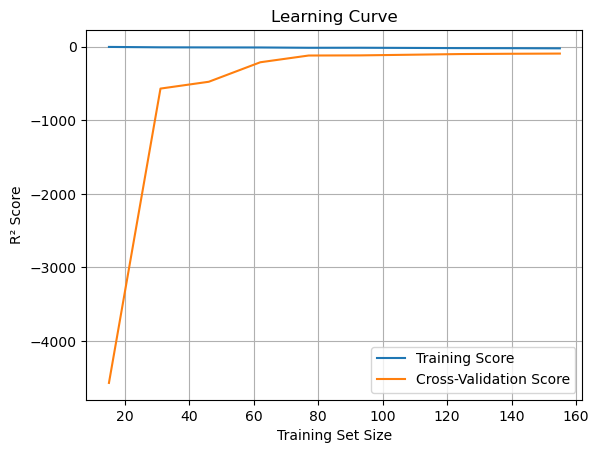

In [17]:
train_sizes, train_scores, test_scores = learning_curve(
    xgbCmp_model, X, y, cv=5, scoring='neg_mean_squared_error', train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

plt.plot(train_sizes, train_mean, label="Training Score")
plt.plot(train_sizes, test_mean, label="Cross-Validation Score")
plt.xlabel("Training Set Size")
plt.ylabel("R² Score")
plt.legend()
plt.title("Learning Curve")
plt.grid(True)
plt.show()

### Notes on Training vs Testing Eval Metrics

### Random State 42:

***Testing Stats:***

- R²: 0.9853

- Mean Absolute Error (MAE): 7.651

- Mean Squared Error (MSE): 103.0002

- Root Mean Squared Error (RMSE): 10.1489

***Training Stats:***

- R²: 0.99707

- Mean Absolute Error (MAE): 3.345

-  Mean Squared Error (MSE): 18.4969

- Root Mean Squared Error (RMSE): 4.3008

The training RSME and MAE are both over half of the testing data's corresponding metrics. This suggests this model is overfitted.

While I believe both scores are quite good (and they have a similar $R^2$ of 0.9853 for testing and 0.99707 for testing), the difference of $\approx 5.85$ cmps between testing and training data can be considered non-insignificant. After all, that's more than double. Furthermore, if we assume the average number of completions by a QB over a season is around 300, then the MAE of 3.345 or 7.651 are both relatively low. But once again, the testing data's MAE is double that of the training data's MAE, which is a pretty alarming difference.

### Random State 99:

***Testing Stats:***

- R²: 0.9821521639823914

- Mean Absolute Error (MAE): 6.5758056640625

- Mean Squared Error (MSE): 84.68156433105469

- Root Mean Squared Error (RMSE): 9.202258653779229

***Training Stats:***

- R²: 0.9972654581069946

- Mean Absolute Error (MAE): 3.3658158779144287

- Mean Squared Error (MSE): 18.78411865234375

- Root Mean Squared Error (RMSE): 4.334064910951813

We see similar results (i.e. both have relatively low errors but testing metrics are over double of corresponding training metrics).

### Analysis

Moreover, given the already relatively limited sample size of passers, can we trust this model's accuracy over long-term xCmp calculations? Additionally, how can we ensure we didn't get lucky with this particular model and that if we consistently used these features to calculate xCmp, we can consistently get good RMSE numbers (e.g. what if we got lucky with this seed)? Also, the MSE is very different, implying the testing data had some outliers the model poorly fitted. It is unclear whether this is because the model is overfitted or because the outliers in the testing data are that extreme. 

Considering the high amount of variance in football, it's possible these differences in evaluation scores are not abnormal. Additionally, since XGBoost models are quite complex and powerful, differences between testing/training evaluation metrics are expected. Once again, both metric numbers in context are not dramatic. There should be a difference between completions and xCmp anyway, given how xCmp is supposed to be what the QB *should* achieve rather than what they did achieve.

The learning curve provides conflicting evidence, as the training score's constant high score (regardless of scoring metric) suggests the model is well-fitted or even under-fitted. The cross-validation score's behavior (also regardless of scoring metric) tends to increase sharply before plateauing at around size 80. This behavior also contradicts the idea that the model is overfitting. However, it should be noted that the training score's constantly perfect score could be an error from the learning curve plot.

##### Current Parameters
```
xgbCmp_model = XGBRegressor(
    objective='reg:squarederror',  # for regression
    n_estimators=50,
    learning_rate=0.1,
    max_depth=3,
    tree_method='hist',
    random_state=99
)
```

##### Possible Improvements
- Figure out ways to reduce overfititng in XGBoost models in general (i.e. greater max_depth, n_estimators, etc.)
- Feature engineering

/opt/anaconda3/envs/footballXGB/lib/python3.10/site-packages/xgboost/plotting.py:267: FutureWarning: The `num_trees` parameter is deprecated, use `tree_idx` insetad. 
  warnings.warn(


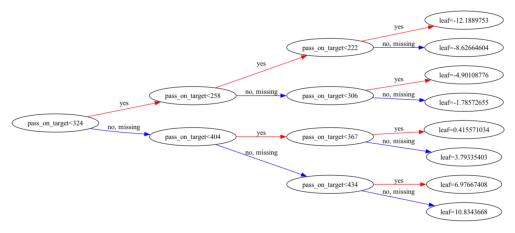

In [18]:
# Visualize xgb model

xgb.plot_tree(xgbCmp_model.get_booster(), num_trees=0,  rankdir='LR') 
plt.show()

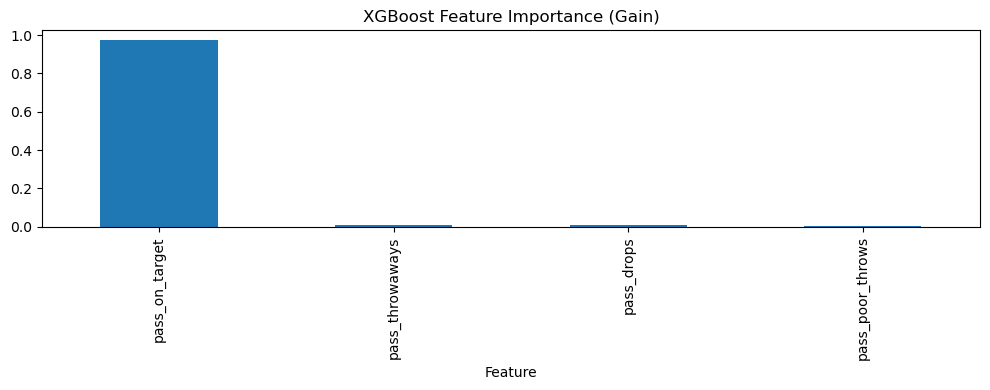

In [19]:
# Plot feature importance

importance = xgbCmp_model.feature_importances_
features = X_train.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importance})
importance_df.sort_values(by='Importance', ascending=False, inplace=True)

# Plot
importance_df.plot.bar(x='Feature', y='Importance', legend=False, figsize=(10, 4))
plt.title("XGBoost Feature Importance (Gain)")
plt.tight_layout()
plt.show()

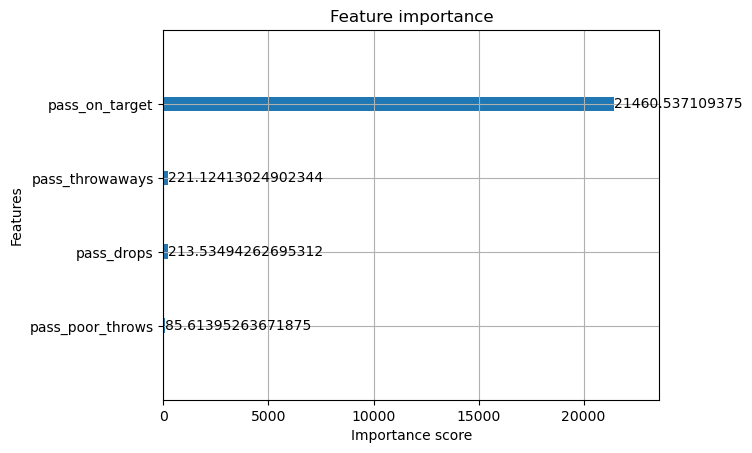

In [20]:
xgb.plot_importance(xgbCmp_model, importance_type='gain')  # options: 'weight', 'gain', 'cover'
plt.show()


In [22]:
X.corr()['pass_on_target'].sort_values(ascending=False)


pass_on_target      1.000000
pass_poor_throws    0.721522
pass_drops          0.717985
pass_throwaways     0.411463
Name: pass_on_target, dtype: float64

### VISUALIZE xCMP

In [20]:
# Create new columns for visuals based on new data from the model


xCmp_data['cmpPct'] = (xCmp_data['pass_cmp']/xCmp_data['pass_att'])

xCmp_data['xAtt'] = xCmp_data['pass_att'] - xCmp_data['pass_spikes']

xCmp_data['xCmp'] = xgbCmp_model.predict(X)

xCmp_data['xCmpPct'] = (xCmp_data['xCmp']/xCmp_data['xAtt']) * 100

xCmp_data['xCmpPctDiff'] = (xCmp_data['xCmpPct'] - xCmp_data['cmpPct'])

xCmp_data['xCmpDiff'] = xCmp_data['xCmp'] - xCmp_data['pass_cmp'] 

In [38]:
# Filter data to 2024 stats

data24 = xCmp_data[xCmp_data['Season'] == "2024"]

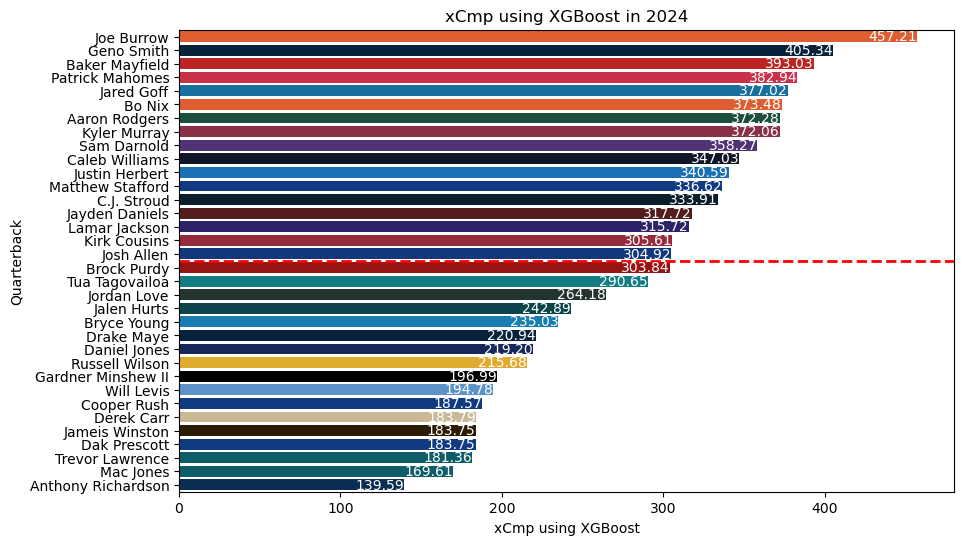

In [31]:
xCmp24_graph = statGrapher(data24, 'xCmp', 'xCmp using XGBoost', pct=False)

# Consider rounding/truncating decimals

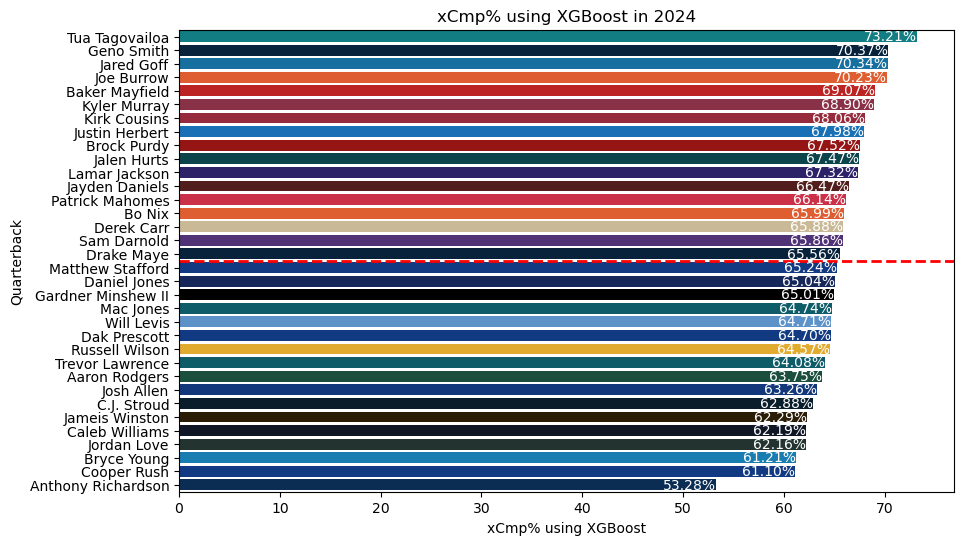

In [39]:
xCmpPct24_graph = statGrapher(data24, 'xCmpPct', 'xCmp% using XGBoost')

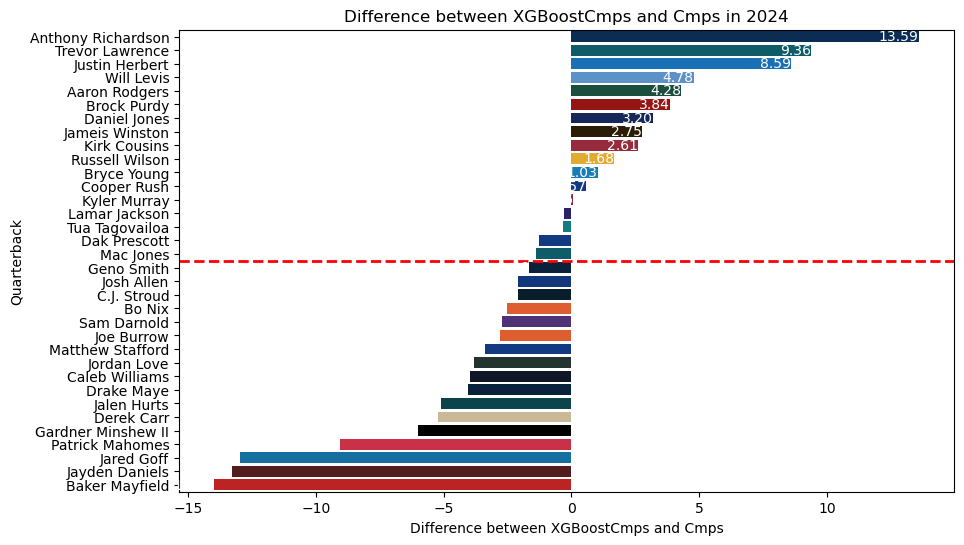

In [36]:
xCmp_diff_graph = statGrapher(data24, 'xCmpDiff', 'Difference between XGBoostCmps and Cmps', pct = False)


In [21]:
# 2024 xCmp% based on model

xCmpPct24_diff_graph = statGrapher(data24, 'xCmpPctDiff', 'Difference between XGBoostCmp% and Cmp%')

# NOTE: cmp% won't display for players with negative values because text is HA'd right & is white text

NameError: name 'data24' is not defined

# xCmp with OL Factors Model

Note: the way this model currently works is that actually rewards QBs whho's actual cmp% is better than their xCmp%. This is because a bad OL should lower their xCmp, so if a QB has more Cmp than their xCmp, it implies they did a good job of circumventing their OL. 

Since we want to make it seem like QBs who have more Cmp than xCmp are lucky rather than skilled, we want to reconfigure this model to reflect that philosophy. We need to find a way to somehow isolate OL-related features from the model while still finding a way to incorporate them into our xCmp calculations.

In [23]:
# Re-create X and y

X = xCmpOL_data[['pass_throwaways', 'pass_poor_throws', 'pass_on_target', 'pass_drops', 'pocket_time', 'pass_blitzed',
                'pass_pressured', 'rush_scrambles']]
y = xCmpOL_data[['pass_cmp']]

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)

In [25]:
# create xgb model

xgbCmpOL_model = XGBRegressor(
    objective='reg:squarederror',  # for regression
    n_estimators=50,
    learning_rate=0.1,
    max_depth=3,
    tree_method='hist',
    random_state=99
)


In [26]:
xgbCmpOL_model.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [27]:
# Get predictions
y_pred = xgbCmpOL_model.predict(X_test)

y_train_pred = xgbCmpOL_model.predict(X_train)

In [28]:
# Evaluation Metrics for TESTING data

calcEval(y_test, y_pred)


R²: 0.981721818447113
Mean Absolute Error (MAE): 6.630801677703857
Mean Squared Error (MSE): 86.72349548339844
Root Mean Squared Error (RMSE): 9.312545059402314


In [29]:
# Evaluation Metrics for TRAINING data

calcEval(y_train, y_train_pred)


R²: 0.9973320960998535
Mean Absolute Error (MAE): 3.2863221168518066
Mean Squared Error (MSE): 18.326234817504883
Root Mean Squared Error (RMSE): 4.280915184572673


### Analysis on Eval Metrics

### Random State 99:

***Testing Stats:***

- R²: 0.9821521639823914

- Mean Absolute Error (MAE):6.630801677703857

- Mean Squared Error (MSE): 86.72349548339844

- Root Mean Squared Error (RMSE): 9.312545059402314

***Training Stats:***

- R²: 0.0.9973320960998535

- Mean Absolute Error (MAE): 3.3.2863221168518066

- Mean Squared Error (MSE): 18.18.326234817504883

- Root Mean Squared Error (RMSE): 4.280915184572673

These numbers are nearly identical to the corresponding metrics for the basic xCmp model.


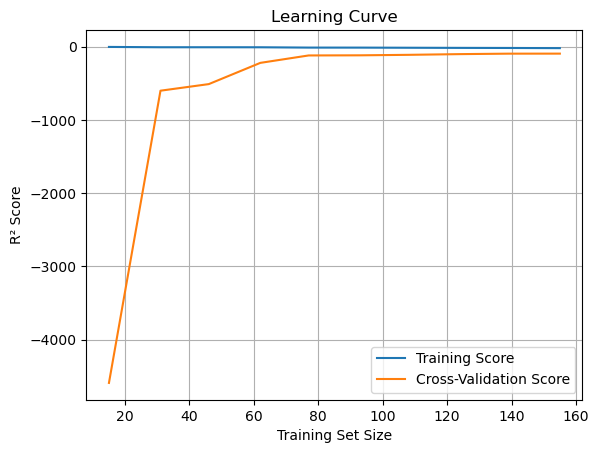

In [30]:
train_sizes, train_scores, test_scores = learning_curve(
    xgbCmpOL_model, X, y, cv=5, scoring='neg_mean_squared_error', train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

plt.plot(train_sizes, train_mean, label="Training Score")
plt.plot(train_sizes, test_mean, label="Cross-Validation Score")
plt.xlabel("Training Set Size")
plt.ylabel("R² Score")
plt.legend()
plt.title("Learning Curve")
plt.grid(True)
plt.show()

/opt/anaconda3/envs/footballXGB/lib/python3.10/site-packages/xgboost/plotting.py:267: FutureWarning: The `num_trees` parameter is deprecated, use `tree_idx` insetad. 
  warnings.warn(


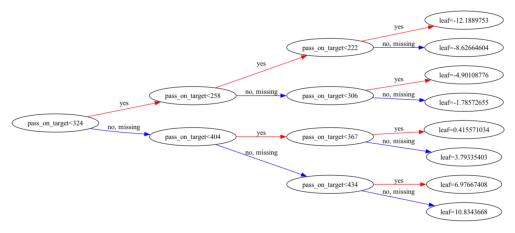

In [30]:
# Visualize new model with OL features

xgb.plot_tree(xgbCmpOL_model.get_booster(), num_trees=0,  rankdir='LR') 
plt.show()

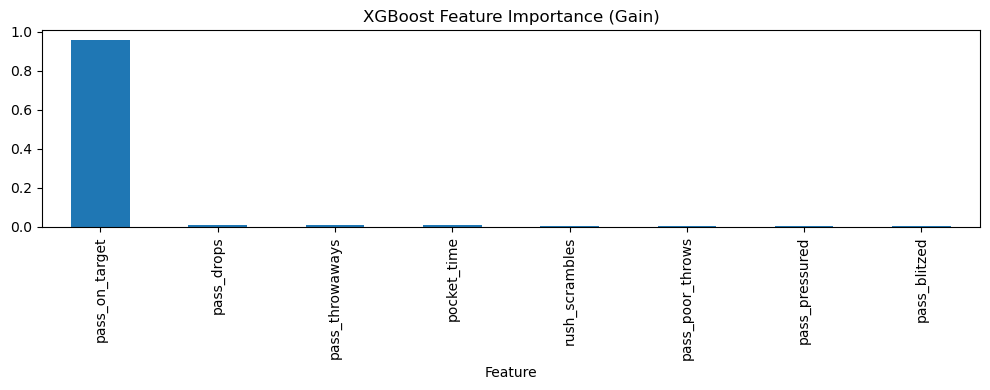

In [32]:
# Plot feature importance

importance = xgbCmpOL_model.feature_importances_
features = X_train.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importance})
importance_df.sort_values(by='Importance', ascending=False, inplace=True)

# Plot
importance_df.plot.bar(x='Feature', y='Importance', legend=False, figsize=(10, 4))
plt.title("XGBoost Feature Importance (Gain)")
plt.tight_layout()
plt.show()

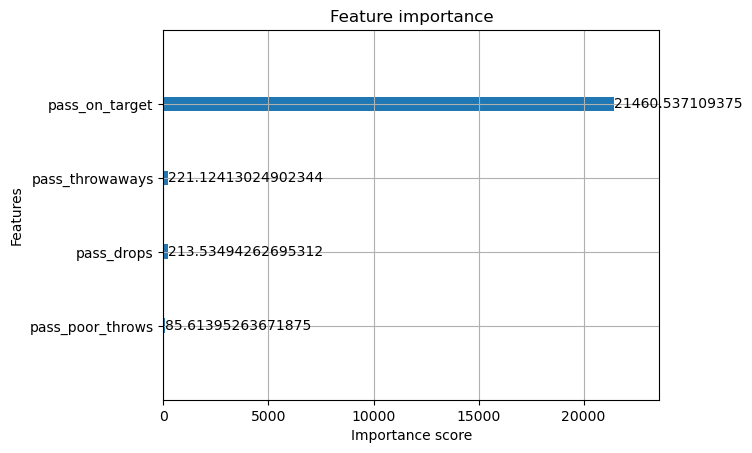

In [33]:
xgb.plot_importance(xgbCmp_model, importance_type='gain')  # options: 'weight', 'gain', 'cover'
plt.show()


### Visualize xCmpOL

In [31]:
# Create new columns for visuals based on new data from the model

# This time for xCmpOL_data

xCmpOL_data['cmpPct'] = (xCmpOL_data['pass_cmp']/xCmpOL_data['pass_att'])

xCmpOL_data['xAtt'] = xCmpOL_data['pass_att'] - xCmpOL_data['pass_spikes']

xCmpOL_data['xCmpOL'] = xgbCmpOL_model.predict(X)

xCmpOL_data['xCmpOLPct'] = (xCmpOL_data['xCmpOL']/xCmpOL_data['xAtt']) * 100

xCmpOL_data['xCmpOLPctDiff'] = (xCmpOL_data['xCmpOLPct'] - xCmpOL_data['cmpPct'])

xCmpOL_data['xCmpOLDiff'] = xCmpOL_data['xCmpOL'] - xCmpOL_data['pass_cmp'] 

In [32]:
# Filter data to 2024 stats

data24 = xCmpOL_data[xCmpOL_data['Season'] == "2024"]

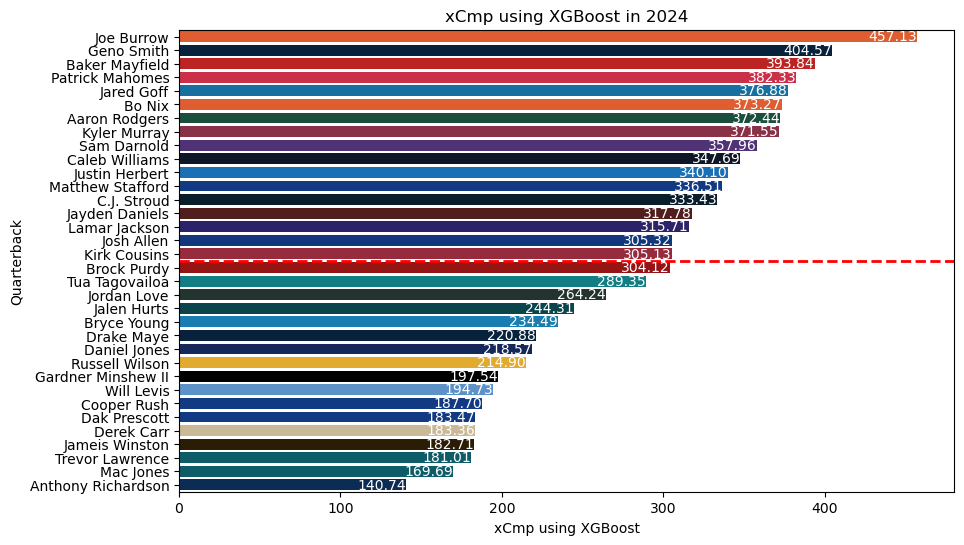

In [33]:
xCmpOL24_graph = statGrapher(data24, 'xCmpOL', 'xCmp using XGBoost', pct=False)

# Consider rounding/truncating decimals

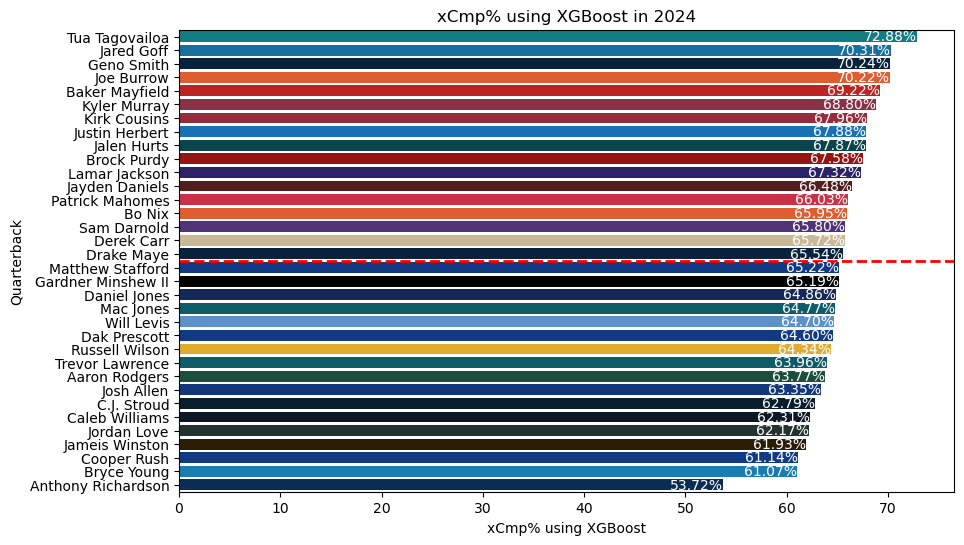

In [34]:
xCmpOLPct24_graph = statGrapher(data24, 'xCmpOLPct', 'xCmp% using XGBoost')

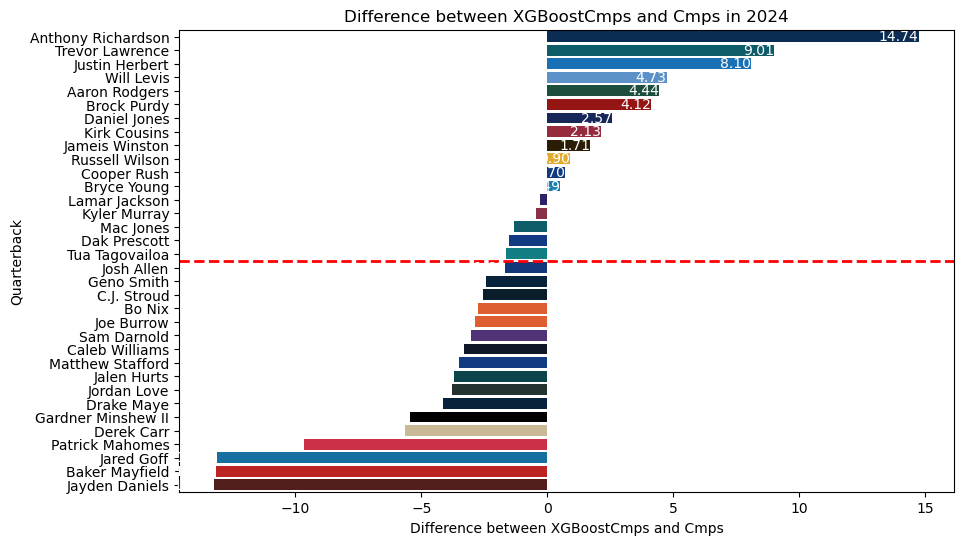

In [35]:
xCmpOL_diff_graph = statGrapher(data24, 'xCmpOLDiff', 'Difference between XGBoostCmps and Cmps', pct = False)


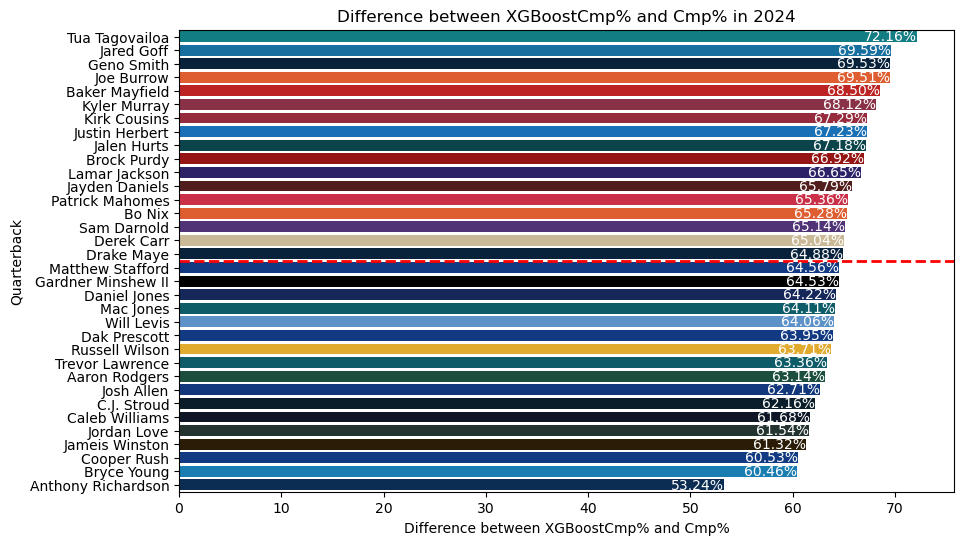

In [36]:
# 2024 xCmp% based on model

xCmpOLPct24_diff_graph = statGrapher(data24, 'xCmpOLPctDiff', 'Difference between XGBoostCmp% and Cmp%')

# NOTE: cmp% won't display for players with negative values because text is HA'd right & is white text

# EXPORTING NEW DATAFRAMES

In [2]:
# Export dfs to CSVs

# TODO: Find way to separate xCmp_data by year and export data per season to a unique CSV
xCmp_data.to_csv('data/xCmp_data/xCmp_passing.csv', index=False)

xCmpOL_data.to_csv('data/xCmp_data/xCmpOL_passing.csv', index=False)

'''
for x in years:
    df = data[x]
    df.to_csv('data/xCmp_data/xCmp_passing_20' + str(x) + '.csv', index=False)
'''

"\nfor x in years:\n    df = data[x]\n    df.to_csv('data/xCmp_data/xCmp_passing_20' + str(x) + '.csv', index=False)\n"